# Predicting future actor collaborations using Graph Analytics in Neo4j

## Introduction

* **Objective**: use graph features to predict future collaboration between actors based on previous collaboration.

* 4 models are trained and tested using different set of graph features.

* The last section presents the importance of each of the features used on the prediction performance.

* The graph parameters used are: Common neighbors, preferential attachment, total neighbors, triangles count, clustering coefficient, Louvain coefficient, and partition community detection.

Note: this paper is based on the notebook ‘Analyze netflix data using graphs (neo4j)’ published by [Yann Claudel.](https://www.kaggle.com/code/yclaudel/analyze-netflix-data-using-graphs-neo4j)


Diagram of the nodes and relationships

![asdf.PNG](attachment:0b2e4112-4b3b-4f50-b416-57d1ba3c62de.PNG)

# Neoj4 configuration

To interact with Neo4j, you need a Sandbox Neo4j.
​
For this project, I am using the Neo4j desktop version and running the sandbox in my localhost browser, you can install Neo4j following the instruction in this [link](https://neo4j.com/download/).
​
An online sandbox can be launched for 3 days [here](https://neo4j.com/sandbox/), you just have to sign in.
​
In this notebook, I am connecting with my localhost running Neo4j installed in my desktop.
​
**Steps to connect Neo4j desktop and Jupiter notebook:**
​
* Run the neo4j desktop app
* Create a new project (+new button)
* Within the project, create a new Graph DBMS (+add button)
* Select the 'Local DBMS' option in the menu
* When creating the Graph DBMS, select a password and write it down as you will need it later.
* This notebook is using the 5.3.0 neo4j version **5.3.0**
* Once created, click it to open the option toolbar on the right hand side, select the Plugins option and install APOC and Graph Data Science Library
* Then, click on the three dots next to the open button, and select settings
* Go to the button of the text file and change the memory.heap.max_size by 6G

![eeee.PNG](attachment:9fb07807-eefa-4b67-92f7-77c06a64b675.PNG)

## Import the dataset to Neo4j

To import the dataset to neo4j first:
​
* Open the import folder
​
![zzz.PNG](attachment:28c5b61d-93e4-403f-823f-f4a619f8de3e.PNG)
​
* Copy and past the dataset in the import folder
* Press the start button to run the neo4j sandbox
* When running, you will receive a notification that the process was successful
* Finally, open the virtual sandbox by selecting the open button and Neo4j Browser option.
* **At this point, you should have neo4j running in your localhost and ready to start coding in your notebook**

# Coding in Jupyter Notebook

In [ ]:
!pip install py2neo pandas

In [ ]:
import numpy as np
import pandas as pd
from py2neo import Graph
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import time

In [ ]:
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
df = pd.read_csv('/kaggle/input/netflix-popular-movies-dataset/n_movies.csv')
df.head()

,movie_id,title,year,classification,duration_min,genre,rating,description,stars,votes
0,1,Cobra Kai,2018,TV-14,30,"Action,Comedy,Drama",8.500,Decades after their 1984 All Valley Karate Tou...,"Ralph Macchio,William Zabka,Courtney Henggeler...","177,031"
1,2,The Crown,2016,TV-MA,58,"Biography,Drama,History",8.700,Follows the political rivalries and romance of...,"Claire Foy,Olivia Colman,Imelda Staunton,Matt ...","199,885"
2,3,Better Call Saul,2022,TV-MA,46,"Crime,Drama",8.900,The trials and tribulations of criminal lawyer...,"Bob Odenkirk,Rhea Seehorn,Jonathan Banks,Patri...","501,384"
3,4,Devil in Ohio,2022,TV-MA,356,"Drama,Horror,Mystery",5.900,When a psychiatrist shelters a mysterious cult...,"Emily Deschanel,Sam Jaeger,Gerardo Celasco,Mad...","9,773"
4,5,Cyberpunk: Edgerunners,2022,TV-MA,24,"Animation,Action,Adventure",8.600,A Street Kid trying to survive in a technology...,"Zach Aguilar,Kenichiro Ohashi,Emi Lo,Aoi Yki","15,413"


## Connection neo4j and jupyter notebook

In [ ]:
#In this code just change the password for your password
graph = Graph("bolt://localhost", auth=("neo4j", "Chicharo2"))

In [ ]:
#Set true to load all the nodes and relationship
LOAD_DATA = True
#Set False after creating all the nodes to avoid creating them again

def run_request(request,LOAD_DATA=False):
    if (LOAD_DATA):
        start_time = time.time()
        print(graph.run(request))
        exec_time = time.time() - start_time
        print(f'-- {exec_time} seconds --')

In [ ]:
# DELETE ALL NODES AND RELATIONSHIPS
request_delete ="""
MATCH (n) DETACH DELETE n;
"""
run_request(request_delete,LOAD_DATA)

(No data)

-- 0.08922600746154785 seconds --


In [ ]:
# CREATE MOVIES

request ="""
CREATE (m:Movie {id: $movie_id,title: $title})
SET
m.year = $year,
m.classification = $classification,
m.duration_min = $duration_min,
m.genre = $genre,
m.rating = $rating,
m.stars = $stars,
m.votes = $votes
"""
start_time = time.time()
count=df.shape[0]
if (LOAD_DATA):
    for index, row in df.iterrows():
        graph.run(request,
                  movie_id=row['movie_id'],
                  title=row['title'],
                  duration_min=None if pd.isnull(row['duration_min']) else row['duration_min'],
                  genre=None if pd.isnull(row['genre']) else row['genre'],
                  classification=None if pd.isnull(row['classification']) else row['classification'],
                  stars= None if pd.isnull(row['stars']) else row['stars'],
                  year=None if pd.isnull(row['year']) else row['year'],
                  rating=None if pd.isnull(row['rating']) else row['rating'],
                  votes=None if pd.isnull(row['votes']) else row['votes']
                  )
        if (index%500==0):
            exec_time = time.time() - start_time
            print(f'{index}/{df.shape[0]} done ... -- {exec_time} seconds --')

    exec_time = time.time() - start_time
    print(f' ... End ... -- {exec_time} seconds --')

0/7162 done ... -- 0.12423396110534668 seconds --

500/7162 done ... -- 2.8049380779266357 seconds --

1000/7162 done ... -- 4.970197677612305 seconds --

1500/7162 done ... -- 6.9788007736206055 seconds --

2000/7162 done ... -- 9.021366119384766 seconds --

2500/7162 done ... -- 10.981455087661743 seconds --

3000/7162 done ... -- 12.835126638412476 seconds --

3500/7162 done ... -- 14.728368520736694 seconds --

4000/7162 done ... -- 16.7145414352417 seconds --

4500/7162 done ... -- 18.5065758228302 seconds --

5000/7162 done ... -- 20.32051134109497 seconds --

5500/7162 done ... -- 22.01297903060913 seconds --

6000/7162 done ... -- 23.64810609817505 seconds --

6500/7162 done ... -- 25.307291984558105 seconds --

7000/7162 done ... -- 26.933125972747803 seconds --

 ... End ... -- 27.461460828781128 seconds --


In [ ]:
# CREATE  PERSONS
request ="""
MATCH (m:Movie)
WHERE m.stars IS NOT NULL
WITH m
UNWIND split(m.stars, ',') AS actor
MERGE (a:Actor {name: trim(actor)})
MERGE (a)-[r:ACTED_IN]->(m);
"""
run_request(request,LOAD_DATA)

(No data)

-- 119.89181542396545 seconds --


In [ ]:
# CREATE CATEGORIES
request ="""
MATCH (m:Movie)
WHERE m.genre IS NOT NULL
WITH m
UNWIND split(m.genre, ',') AS genre
MERGE (g:Genre {name: trim(genre)})
MERGE (m)-[r:IN_GENRE]->(g);
"""
run_request(request,LOAD_DATA)

(No data)

-- 0.6003000736236572 seconds --


In [ ]:
# DELETE UNUSED PROPERTY
request="""
MATCH(m:Movie)
SET m.country = null, m.category = null,m.type = null , m.director = null , m.cast =null
"""
run_request(request,LOAD_DATA)

(No data)

-- 0.07618927955627441 seconds --


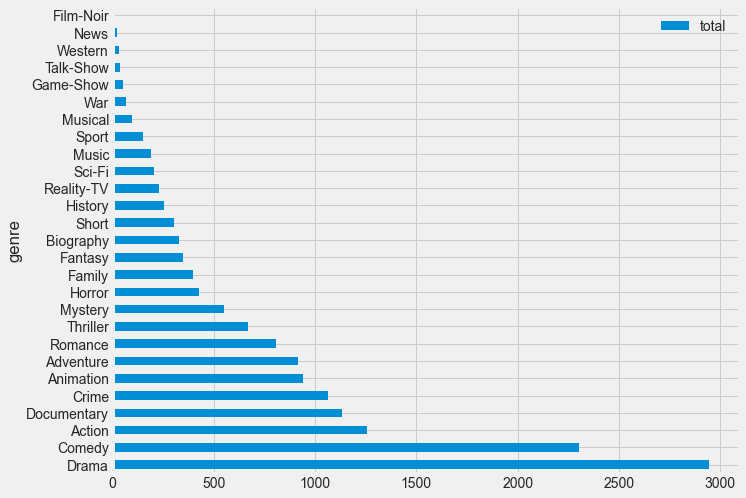

In [ ]:
request="""
MATCH (g:Genre)<-[rel:IN_GENRE]-(m:Movie)
WITH g.name as genre,count(*) as total
RETURN  genre,total
ORDER BY total DESC
"""
result = graph.run(request).to_data_frame()
result.plot.barh(x='genre', y='total',figsize=(10,8))
plt.show()

In [ ]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Genre,27
0,Movie,7162
1,Actor,22268


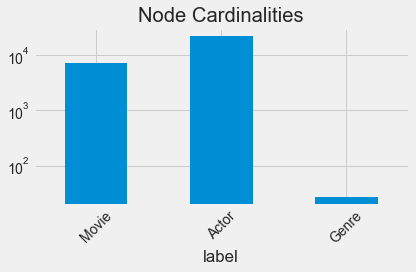

In [ ]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#Shortest Path analysis

def who_be_present(I_AM,I_WANT_TO_MEET):
    print(f"I'm {I_AM}")
    print(f"I want to meet {I_WANT_TO_MEET}")
    request="""
MATCH p = shortestPath((start:Actor)-[:WORK_WITH*]-(end:Actor))
WHERE start.name = $pfrom AND end.name = $pto
RETURN p

    """
    cursor = graph.run(request,pfrom=I_AM,pto=I_WANT_TO_MEET)
    while cursor.forward():
        print(cursor['p'])
    print('\n')


I_AM='Johnny Yong Bosch'
I_WANT_TO_MEET='Jakob Eklund'
who_be_present(I_AM,I_WANT_TO_MEET)

I_AM='Matt Smith'
I_WANT_TO_MEET='Johnny Yong Bosch'
who_be_present(I_AM,I_WANT_TO_MEET)

I'm Johnny Yong Bosch

I want to meet Jakob Eklund





I'm Matt Smith

I want to meet Johnny Yong Bosch






## Splitting the dataset

Based on the graph presented above, all the movies released before 2020 are taken as training dataset and the movies released in 2020 onwards are taken as testing dataset

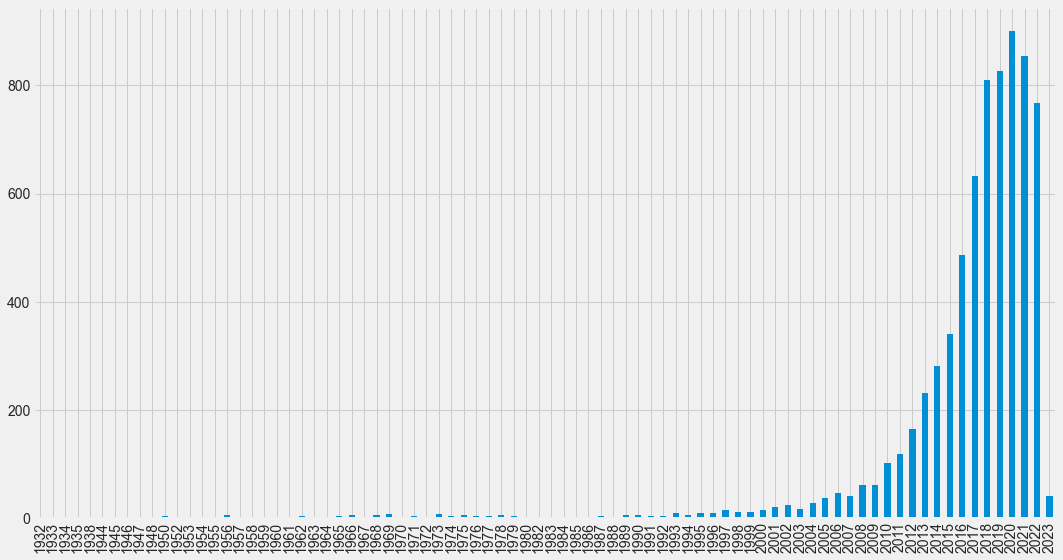

In [ ]:
query = """
MATCH (m:Movie) WHERE (m.year) IS NOT NULL
WITH m.year AS year, count(*) AS count
ORDER BY year
RETURN toString(year) AS year, count
"""
by_year = graph.run(query).to_data_frame()

ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [ ]:
#Creating work_with relationship
query = """
MATCH (a:Actor)-[rel:ACTED_IN]->(movie)<-[:ACTED_IN]-(a2:Actor)
WITH a, a2, movie
ORDER BY a, movie.year
WITH a, a2, collect(movie)[0].year AS year, count(*) AS collaborations
MERGE (a)-[work_with:WORK_WITH {year: year}]-(a2)
SET work_with.collaborations = collaborations;
"""

graph.run(query).stats()

{'relationships_created': 53585, 'properties_set': 160755}

In [ ]:
#Creating work_with_early relationship (train dataset)
query = """
MATCH (a:Actor)-[rel:ACTED_IN]->(movie)<-[:ACTED_IN]-(a2:Actor)
WITH a, a2, movie
ORDER BY a, movie.year
WITH a, a2, collect(movie)[0].year AS year, count(*) AS collaborations
WHERE year < 2020
MERGE (a)-[work_with:WORK_WITH_EARLY {year: year}]-(a2)
SET work_with.collaborations = collaborations;
"""

graph.run(query).stats()

{'relationships_created': 35771, 'properties_set': 107313}

In [ ]:
#Creating work_with_late relationship (test dataset)
query = """
MATCH (a:Actor)-[rel:ACTED_IN]->(movie)<-[:ACTED_IN]-(a2:Actor)
WITH a, a2, movie
ORDER BY a, movie.year
WITH a, a2, collect(movie)[0].year AS year, count(*) AS collaborations
WHERE year >= 2020
MERGE (a)-[work_with:WORK_WITH_LATE {year: year}]-(a2)
SET work_with.collaborations = collaborations;
"""

graph.run(query).stats()

{'relationships_created': 17814, 'properties_set': 53442}

In [ ]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
1,IN_GENRE,15721
4,WORK_WITH_LATE,17814
0,ACTED_IN,30806
3,WORK_WITH_EARLY,35771
2,WORK_WITH,53585


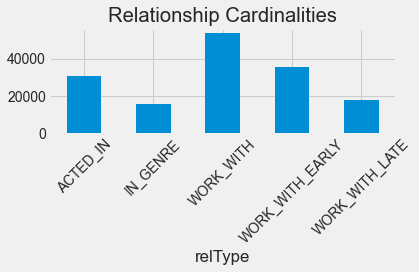

In [ ]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
query = """
MATCH ()-[:WORK_WITH_EARLY]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,35771


In [ ]:
query = """
MATCH ()-[:WORK_WITH_LATE]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,17814


## Down sampling the unconnected nodes

Due to the number of no related nodes (or actors who haven't collaborated before) is higher than the number of nodes related (unbalanced data). We need to downsampling the unrelated nodes to the same number of connected nodes.

* The actors who have collaborated before are represented with the number 1.

* The actors who haven't collaborated before are represented with the number 0.

In [ ]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [ ]:
#Correcting unbalanced issue in the training dataset

train_existing_links = graph.run("""
MATCH (a:Actor)-[:WORK_WITH_EARLY]->(other:Actor)
RETURN id(a) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links = graph.run("""
MATCH (a:Actor)
WHERE (a)-[:WORK_WITH_EARLY]-()
MATCH (a)-[:WORK_WITH_EARLY*2..3]-(other)
WHERE not((a)-[:WORK_WITH_EARLY]-(other))
RETURN id(a) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links = train_missing_links.drop_duplicates()

In [ ]:
training_df = pd.concat([train_missing_links, train_existing_links], ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

In [ ]:
training_df.head()

,node1,node2,label
731957,11213,22326,1
725798,18640,18641,1
724794,17946,17947,1
621354,22834,12111,0
231092,9609,8250,0


In [ ]:
#balanced training dataset
training_df.groupby("label").count()

,node1,node2
label,,
0,35771,35771
1,35771,35771


In [ ]:
#Correcting unbalanced issue in the testing dataset

test_existing_links = graph.run("""
MATCH (a:Actor)-[:WORK_WITH_LATE]->(other:Actor)
RETURN id(a) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run("""
MATCH (a:Actor)
WHERE (a)-[:WORK_WITH_LATE]-()
MATCH (a)-[:WORK_WITH_LATE*2..3]-(other)
WHERE not((a)-[:WORK_WITH_LATE]-(other))
RETURN id(a) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links = test_missing_links.drop_duplicates()

In [ ]:
test_df = pd.concat([test_missing_links, test_existing_links], ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

In [ ]:
test_df.head()

,node1,node2,label
54088,13035,7572,0
87433,18506,16029,0
117418,12605,12606,1
2923,7347,9557,0
128705,27241,27244,1


In [ ]:
#balanced testing dataset
test_df.groupby("label").count()

,node1,node2
label,,
0,17814,17814
1,17814,17814


## Choosing a machine learning algorithm

In [ ]:
#Random Forest Classifier used as model
classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)

### Calculating grahp parameters (cn, pa, tn)

In [ ]:
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           gds.alpha.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           gds.alpha.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           gds.alpha.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [ ]:
training_df = apply_graphy_features(training_df, "WORK_WITH_EARLY")

In [ ]:
training_df.head()

,node1,node2,label,cn,pa,tn
0,11213,22326,1,2.000,84.000,18.000
1,18640,18641,1,2.000,9.000,4.000
2,17946,17947,1,3.000,16.000,5.000
3,22834,12111,0,0.000,16.000,8.000
4,9609,8250,0,1.000,114.000,40.000


In [ ]:
test_df = apply_graphy_features(test_df, "WORK_WITH_LATE")

In [ ]:
test_df.head()

,node1,node2,label,cn,pa,tn
0,13035,7572,0,1.000,56.000,17.000
1,18506,16029,0,1.000,28.000,10.000
2,12605,12606,1,2.000,21.000,8.000
3,7347,9557,0,0.000,24.000,10.000
4,27241,27244,1,3.000,16.000,5.000


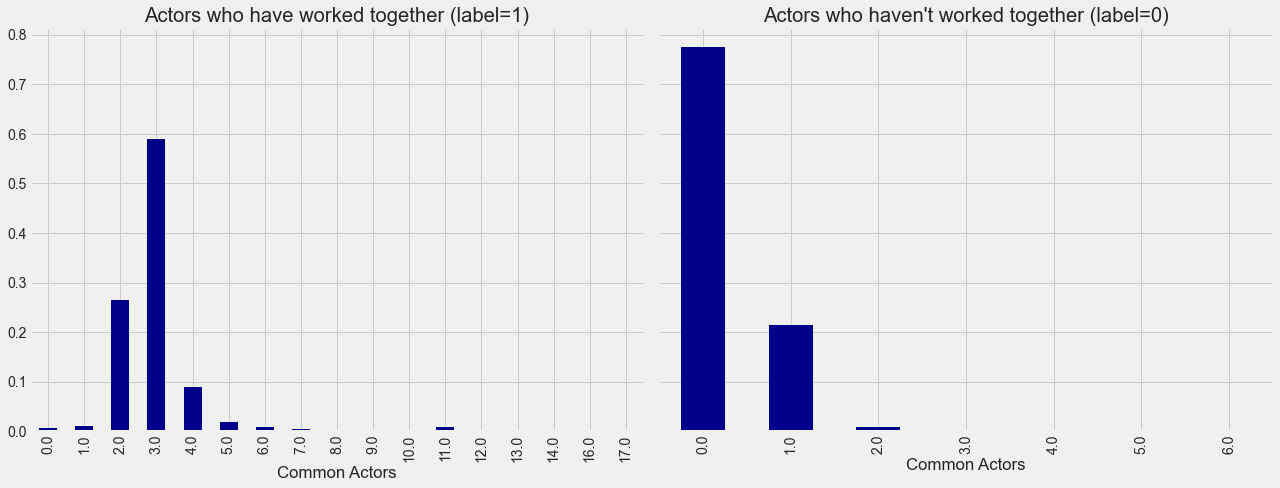

In [ ]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have worked together"), (0, "haven't worked together")]
for index, chart in enumerate(charts):
 label, title = chart
 filtered = training_df[training_df["label"] == label]
 common_actors = filtered["cn"]
 histogram = common_actors.value_counts().sort_index()
 histogram /= float(histogram.sum())
 histogram.plot(kind="bar", x='Common Actors', color="darkblue",
 ax=axs[index], title=f"Actors who {title} (label={label})")
 axs[index].xaxis.set_label_text("Common Actors")
plt.tight_layout()
plt.show()

### Model 1: using just 'cn' as feature

In [ ]:
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))
display("AUC",roc_auc_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.9739250028067812

'Precision'

0.9848389134554643

'Recall'

0.962669810261592

'AUC'

0.9739250028067811

[('cn', 1.0)]

In [ ]:
#Model results
results = pd.DataFrame([accuracy_score(y_test, predictions),precision_score(y_test, predictions),recall_score(y_test, predictions),roc_auc_score(y_test, predictions)], index=["Accuracy", "Precision", "Recall", "AUC"], columns=["Model 1"])
results

,Model 1
Accuracy,0.974
Precision,0.985
Recall,0.963
AUC,0.974


### Model 2: using 'cn', 'pa', and 'tn' as features

In [ ]:
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))
display("AUC",roc_auc_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.9797069720444594

'Precision'

0.9844662395827428

'Recall'

0.9747951049736162

'AUC'

0.9797069720444594

[('cn', 0.7313016453208196),
 ('tn', 0.19694197130911453),
 ('pa', 0.0717563833700658)]

In [ ]:
#Results
m2l = [accuracy_score(y_test, predictions),precision_score(y_test, predictions),recall_score(y_test, predictions),roc_auc_score(y_test, predictions)]
results['Model 2'] = m2l
results

,Model 1,Model 2
Accuracy,0.974,0.980
Precision,0.985,0.984
Recall,0.963,0.975
AUC,0.974,0.980


### Calculating triangle counts and cluster coefficient

In [ ]:
graph.run("""
CALL gds.graph.project(
  'Actor',
  'Actor',
  {WORK_WITH_EARLY: {orientation: 'UNDIRECTED'}}

)
"""
).to_data_frame()

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Actor': {'label': 'Actor', 'properties': {}}}",{'WORK_WITH_EARLY': {'orientation': 'UNDIRECTE...,Actor,22268,71542,2789


In [ ]:
graph.run("""
CALL gds.triangleCount.write('Actor',{
 writeProperty: 'trianglesTrain'
});

""").to_data_frame()

,writeMillis,nodePropertiesWritten,globalTriangleCount,nodeCount,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,112,22268,35140,22268,0,1,44,{'jobId': '6b000609-ea18-4f5a-a7ae-bc92cd3b268...


In [ ]:
graph.run("""
CALL gds.graph.project(
  'ActorLate',
  'Actor',
  {WORK_WITH_LATE: {orientation: 'UNDIRECTED'}}

)
"""
).to_data_frame()

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Actor': {'label': 'Actor', 'properties': {}}}",{'WORK_WITH_LATE': {'orientation': 'UNDIRECTED...,ActorLate,22268,35628,53


In [ ]:
graph.run("""
CALL gds.triangleCount.write('ActorLate',{
 writeProperty: 'trianglesTest'
});

""").to_data_frame()

,writeMillis,nodePropertiesWritten,globalTriangleCount,nodeCount,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,125,22268,15948,22268,0,0,17,{'jobId': 'da5ed597-f28f-414f-a46a-c03b7bced3b...


In [ ]:
graph.run("""
CALL gds.graph.project(
  'ActorCluste1',
  'Actor',
  {WORK_WITH_LATE: {orientation: 'UNDIRECTED'}}
)
"""
).to_data_frame()

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Actor': {'label': 'Actor', 'properties': {}}}",{'WORK_WITH_LATE': {'orientation': 'UNDIRECTED...,ActorCluste1,22268,35628,54


In [ ]:
graph.run("""
CALL gds.localClusteringCoefficient.write('ActorCluste1',{
 writeProperty: 'coefficientTrain'
});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,averageClusteringCoefficient,nodeCount,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,122,22268,0.356,22268,0,1,56,{'jobId': 'a99587e8-2bd7-4d89-8635-977d3ba5e78...


In [ ]:
graph.run("""
CALL gds.graph.project(
  'ActorCluste2',
  'Actor',
  {WORK_WITH_LATE: {orientation: 'UNDIRECTED'}}
)
"""
).to_data_frame()

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Actor': {'label': 'Actor', 'properties': {}}}",{'WORK_WITH_LATE': {'orientation': 'UNDIRECTED...,ActorCluste2,22268,35628,47


In [ ]:
graph.run("""
CALL gds.localClusteringCoefficient.write('ActorCluste2',{
 writeProperty: 'coefficientTest'
});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,averageClusteringCoefficient,nodeCount,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,90,22268,0.356,22268,0,0,31,{'jobId': 'da2c6c8d-e789-4d84-ad85-0770940dcda...


In [ ]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [ ]:
#Uncomment to create the the 4 new features and add them to the dataframe
training_df = apply_triangles_features(training_df, "trianglesTrain", "coefficientTrain")
test_df = apply_triangles_features(test_df, "trianglesTest", "coefficientTest")

In [ ]:
training_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient
0,11213,22326,1,2.000,84.000,18.000,6,15,0.000,1.000
1,18640,18641,1,2.000,9.000,4.000,3,3,0.000,0.000
2,17946,17947,1,3.000,16.000,5.000,6,6,0.000,0.000
3,22834,12111,0,0.000,16.000,8.000,6,6,0.000,0.273
4,9609,8250,0,1.000,114.000,40.000,3,61,0.176,1.000


In [ ]:
test_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient
0,13035,7572,0,1.000,56.000,17.000,6,27,0.297,1.000
1,18506,16029,0,1.000,28.000,10.000,6,9,0.429,1.000
2,12605,12606,1,2.000,21.000,8.000,3,9,0.429,1.000
3,7347,9557,0,0.000,24.000,10.000,6,6,0.400,1.000
4,27241,27244,1,3.000,16.000,5.000,6,6,1.000,1.000


### Model 3: using graph parameters (cn, pa, tn), triangles, and cluste coefficients as features

In [ ]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient" # triangle features
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))
display("AUC",roc_auc_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.9841416863141349

'Precision'

0.9851493502840749

'Recall'

0.9831031772762996

'AUC'

0.984141686314135

[('cn', 0.7356269509255299),
 ('tn', 0.17314996014180126),
 ('pa', 0.04148402932763873),
 ('maxTriangles', 0.028289133078002043),
 ('minTriangles', 0.014768164318422157),
 ('maxCoefficient', 0.006208737184290631),
 ('minCoefficient', 0.000473025024315228)]

In [ ]:
#Results
m3l = [accuracy_score(y_test, predictions),precision_score(y_test, predictions),recall_score(y_test, predictions),roc_auc_score(y_test, predictions)]
results['Model 3'] = m3l
results

,Model 1,Model 2,Model 3
Accuracy,0.974,0.980,0.984
Precision,0.985,0.984,0.985
Recall,0.963,0.975,0.983
AUC,0.974,0.980,0.984


### Calculating the community detection coefficients

In [ ]:
graph.run("""
CALL gds.labelPropagation.write('Actor',{
 writeProperty: "partitionTrain"
});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,ranIterations,didConverge,communityCount,communityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,78,22268,10,False,8838,"{'p99': 17, 'min': 1, 'max': 753, 'mean': 2.51...",23,0,143,{'jobId': 'a3db854c-9a2d-420c-a2d8-8b137544507...


In [ ]:
graph.run("""
CALL gds.labelPropagation.write('ActorLate',{
 writeProperty: "partitionTest"
});
""").to_data_frame()

,writeMillis,nodePropertiesWritten,ranIterations,didConverge,communityCount,communityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,54,22268,6,True,14777,"{'p99': 11, 'min': 1, 'max': 113, 'mean': 1.50...",13,0,56,{'jobId': '284632bd-f761-45eb-a662-aae04a22eb7...


In [ ]:
graph.run("""
CALL gds.louvain.stream('Actor',{
 includeIntermediateCommunities: true
})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node,
 intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
""").stats()

{'properties_set': 22268}

In [ ]:
graph.run("""
CALL gds.louvain.stream('ActorLate',{
 includeIntermediateCommunities: true
})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node,
 intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
""").stats()

{'properties_set': 22268}

In [ ]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    gds.alpha.linkprediction.sameCommunity(p1, p2, $partitionProp) AS sp,
    gds.alpha.linkprediction.sameCommunity(p1, p2, $louvainProp) AS sl
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [ ]:
training_df = apply_community_features(training_df, "partitionTrain", "louvainTrain")
test_df = apply_community_features(test_df, "partitionTest", "louvainTest")

In [ ]:
training_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl
0,11213,22326,1,2.000,84.000,18.000,6,15,0.000,1.000,1.000,0.000
1,18640,18641,1,2.000,9.000,4.000,3,3,0.000,0.000,1.000,1.000
2,17946,17947,1,3.000,16.000,5.000,6,6,0.000,0.000,1.000,1.000
3,22834,12111,0,0.000,16.000,8.000,6,6,0.000,0.273,1.000,0.000
4,9609,8250,0,1.000,114.000,40.000,3,61,0.176,1.000,0.000,0.000


In [ ]:
test_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl
0,13035,7572,0,1.000,56.000,17.000,6,27,0.297,1.000,1.000,0.000
1,18506,16029,0,1.000,28.000,10.000,6,9,0.429,1.000,1.000,0.000
2,12605,12606,1,2.000,21.000,8.000,3,9,0.429,1.000,1.000,0.000
3,7347,9557,0,0.000,24.000,10.000,6,6,0.400,1.000,0.000,0.000
4,27241,27244,1,3.000,16.000,5.000,6,6,1.000,1.000,1.000,1.000


### Model 4: using graph parameters (cn, pa, tn), triangles, cluste coefficients, and community detection coefficients as features

In [ ]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features
    "sp", "sl" # community features
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))
display("AUC",roc_auc_score(y_test, predictions))
display("Confusion_matrix",confusion_matrix(y_test, predictions, labels = [0,1]))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.9886325362074773

'Precision'

0.9854983546210051

'Recall'

0.991860334568317

'AUC'

0.9886325362074773

'Confusion_matrix'

array([[17554,   260],
       [  145, 17669]], dtype=int64)

[('cn', 0.6446667160858881),
 ('sl', 0.17708355425134864),
 ('sp', 0.0814853038475343),
 ('tn', 0.052284944377609305),
 ('pa', 0.01813653083007172),
 ('maxTriangles', 0.014374727059866666),
 ('minTriangles', 0.01054056725244124),
 ('maxCoefficient', 0.00102907054213552),
 ('minCoefficient', 0.0003985857531044248)]

# Models results

In [ ]:
m4l = [accuracy_score(y_test, predictions),precision_score(y_test, predictions),recall_score(y_test, predictions),roc_auc_score(y_test, predictions)]
results['Model 4'] = m4l
results

,Model 1,Model 2,Model 3,Model 4
Accuracy,0.974,0.980,0.984,0.989
Precision,0.985,0.984,0.985,0.985
Recall,0.963,0.975,0.983,0.992
AUC,0.974,0.980,0.984,0.989


In [ ]:
def plot_feature_importance(fields, feature_importances):
 df = pd.DataFrame({"Feature": fields, "Importance": feature_importances})
 df = df.sort_values("Importance", ascending=False)
 ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None, color="blue", figsize=(13,10))
 ax.xaxis.set_label_text("")
 plt.tight_layout()
 plt.xticks(rotation=45)
 plt.show()

## Features importance

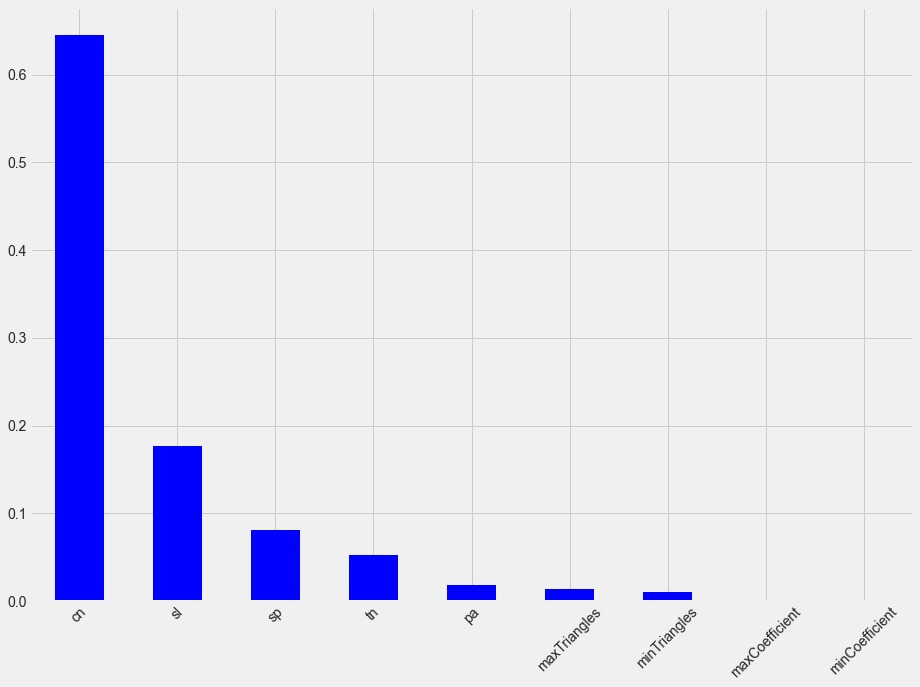

In [ ]:
plot_feature_importance(columns, classifier.feature_importances_)

**Conclusions**:

* Model 4 outstanded the rest of the models with and accuracy of 99% in predicting future collaborations between actors.

* According with the observations, the common Neighbors and the 2 community detection are the most important features when predicting relationships between nodes in this dataset.

***

**License**

This Notebook has been released under the [Apache 2.0](http://www.apache.org/licenses/LICENSE-2.0) open source license.